In [1]:
import sys, os
sys.path.insert(0, os.path.abspath("../pyCudaPolygon"))
import pyCudaPolygon as pcp
import numpy as np
from matplotlib import pyplot as plt

In [2]:
numPolygons = 5
n = 5
m = pcp.model(size = n * numPolygons, seed = 4)
m.setModelEnum("normal")
m.generateRandomPolygon(4, 4, numSteps = 10, tol = 1e-10)

NameError: name 'newtonStep' is not defined

In [ ]:
numPolygons = 5
n = 5
m = pcp.model(size = n * numPolygons, seed = 4)
m.setModelEnum("normal")
# Set all polygons to be equally coordinated
m.setECPolygons(n)
# Set random polygon vertices positions
m.setRandomPolygons()
# Make it so that all of the polygons have the same area
m.setMonoArea(phi = 0.1)
m.draw(numbering = True)
plt.show()

In [16]:
def ddg1xy(x, y, kappa):
    A = area(x, y)
    gradA = dA(x, y)
    HA = ddA(x, y)
    HP = ddP(x, y)

    pref = kappa / (2 * np.sqrt(A))
    outer = np.outer(gradA.flatten(), gradA.flatten())  # (2n, 2n)
    return pref * HA - (kappa / (4 * A**1.5)) * outer - HP

In [17]:
def ddg2xy(x, y):
    n = x.size
    meanP = meanPerimeter(x, y)
    HP2 = ddP2(x, y) / n
    HP = ddP(x, y) / n
    gradP = dP(x, y).flatten() / n
    
    outer = np.outer(gradP, gradP)
    return (HP2 - 2 * meanP * HP - 2 * outer)

In [18]:
def checkSecondDerivative(d, dd, x, y, eps):
    n = x.size
    v = np.random.randn(2 * n)
    v /= np.linalg.norm(v)

    def dFlat(x, y):
        dx, dy = d(x, y)
        return np.concatenate([dx, dy])

    vx = v[:n]
    vy = v[n:]

    gPlus  = dFlat(x + eps * vx, y + eps * vy)
    gMinus = dFlat(x - eps * vx, y - eps * vy)

    HNum = (gPlus - gMinus) / (2 * eps)
    HAn  = dd(x, y) @ v

    err = np.linalg.norm(HAn - HNum) / np.linalg.norm(HNum)
    return err

In [19]:
def L(x, y, vx, vy, l1, l2, kappa):
    dx = x - vx
    dy = y - vy
    c1 = g1(vx, vy, kappa)
    c2 = g2(vx, vy)
    return np.sum(dx * dx + dy * dy - l1 * c1 - l2 * c2)

In [20]:
def dLv(x, y, vx, vy, l1, l2, kappa):
    gradDist = 2 * np.concatenate([vx - x, vy - y])
    gradg1 = l1 * np.concatenate(dg1xy(vx, vy, kappa))
    gradg2 = l2 * np.concatenate(dg2xy(vx, vy))
    return gradDist - gradg1 - gradg2

In [21]:
def dLl(vx, vy, kappa):
    return np.array([g1(vx, vy, kappa), g2(vx, vy)])

In [22]:
def ddLmix(vx, vy, kappa):
    g1_grad = np.concatenate(dg1xy(vx, vy, kappa))
    g2_grad = np.concatenate(dg2xy(vx, vy))
    return -np.column_stack([g1_grad, g2_grad])

In [23]:
def ddLv(vx, vy, l1, l2, kappa):
    return 2*np.eye(2*vx.size) - l1 * ddg1xy(vx, vy, kappa) - l2 * ddg2xy(vx, vy)

In [24]:
def newtonStep(vx, vy, l1, l2, x, y, kappa, alpha=0.02):
    """
    One damped Newton step for the Lagrangian:
        L(v, l) = ||v - x||^2 - l1*g1(v) - l2*g2(v)
    """
    n = vx.size

    # Gradient blocks
    gradV = dLv(x, y, vx, vy, l1, l2, kappa)
    gradLambda = dLl(vx, vy, kappa)

    # Hessian / mixed blocks
    Hvv = ddLv(vx, vy, l1, l2, kappa)
    Hvlambda = ddLmix(vx, vy, kappa)

    # Build full block system
    top = np.hstack([Hvv, Hvlambda])
    bottom = np.hstack([Hvlambda.T, np.zeros((2,2))])
    HBlock = np.vstack([top, bottom])

    # Newton RHS: always negative of the gradient
    rhs = -np.concatenate([gradV, gradLambda])

    # Solve for Newton step
    delta = np.linalg.solve(HBlock, rhs)
#    delta = np.dot(np.linalg.pinv(HBlock), rhs)

    dv = delta[:2 * n]
    dl = delta[2 * n:]

    # Apply damping
    vxNew = vx + alpha * dv[:n]
    vyNew = vy + alpha * dv[n:2 * n]
    l1New = l1 + alpha * dl[0]
    l2New = l2 + alpha * dl[1]

    return vxNew, vyNew, l1New, l2New

In [29]:
def generateRandomPolygon(n, kappa, numSteps = 10, tol = 1e-10):
    pts = np.random.rand(n, 2) - 0.5
    center = pts.mean(axis = 0)
    angles = np.arctan2(pts[:,1] - center[1],
                        pts[:,0] - center[0])
    x, y = pts[np.argsort(angles)].T
    vx = x + 0
    vy = y + 0
    # Actually, let's make a square and perturb it a bit
    x = np.array([-0.5, 0.5, 0.5, -0.5])
    y = np.array([-0.5, -0.5, 0.5, 0.5])
    vx = x + np.random.rand(4) / 100
    vy = y + np.random.rand(4) / 100
    l1 = np.random.rand() - 0.5
    l2 = np.random.rand() - 0.5
    for i in range(numSteps):
        vx, vy, l1, l2 = newtonStep(vx, vy, l1, l2, x, y, kappa)
        print(g1(vx, vy, kappa), g2(vx, vy))
        if np.linalg.norm([g1(vx, vy, kappa), g2(vx, vy)]) < tol:
            break    
    return x, y, vx, vy

In [30]:
x, y, vx, vy = generateRandomPolygon(4, 4)

-5.1978714539657744e-05 1.4977125530779567e-05
-5.3023445680810966e-05 1.5278175356181478e-05
-5.4089175553606594e-05 1.558527647194108e-05
-5.5176326219541494e-05 1.5898550514426013e-05
-5.628532822621324e-05 1.621812156582525e-05
-5.741662077340948e-05 1.654411620188867e-05
-5.8570651887634995e-05 1.6876663542886305e-05
-5.974787860285602e-05 1.7215895305233708e-05
-6.094876713680364e-05 1.756194585156301e-05
-6.217379307837945e-05 1.791495224712225e-05


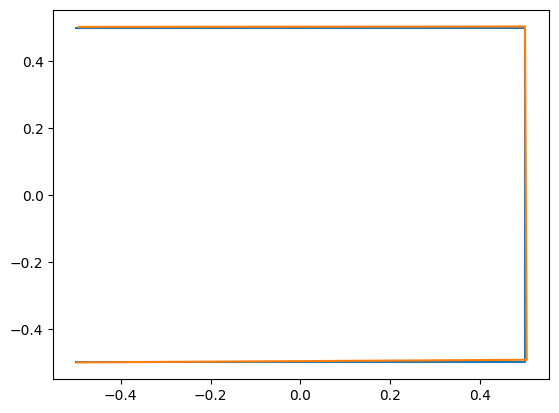

In [31]:
plt.plot(x, y)
plt.plot(vx, vy)
plt.show()

In [ ]:
# What is a reasonable shape index?

In [ ]:
#for a square, that's area 1, perimeter 4 so shape index 4

In [32]:
x = np.array([-0.5, 0.5, 0.5, -0.5])
y = np.array([-0.5, -0.5, 0.5, 0.5])
vx = x + np.random.rand(4) / 100
vy = y + np.random.rand(4) / 100
l1 = np.random.rand() - 0.5
l2 = np.random.rand() - 0.5


In [35]:
meanPerimeter(x, y)

1.0

In [36]:
meanPerimeterSquared(x, y)

1.0

In [37]:
area(x, y)

1.0

In [38]:
getShapeIndex(x, y)

4.0

In [41]:
g1(x, y, 4)

0.0

In [42]:
g2(x, y)

0.0